<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl
import json

from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io
from google.colab import drive


WEIGHTSANDBIASES = True
DOWNLOAD = False
# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'



drive.mount('/content/drive')


if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Streaming output truncated to the last 5000 lines.
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: /content/sample_data/ham

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pjvivesmorey (pjvivesmorey-uib) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [2]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [3]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getpath__(self,index):
    return self.paths[index]

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      #preprocessament
      # lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
      # l, a, b = cv2.split(lab)
      # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
      # l_clahe = clahe.apply(l)
      # lab_clahe = cv2.merge((l_clahe, a, b))
      # image = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)


      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [4]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [5]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)


  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)


  #prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
  #prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
  #prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

  if distribution != None:
    train_data.__redistribute__(distribution)

  return train_data, validation_data,test_data


In [6]:
def get_weights():

  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}

  valors = metadates['dx'].value_counts()
  print(valors)
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1

  weights = weights / weights.sum()

  print((1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]))
  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]) ,weights

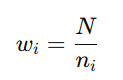

In [7]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [8]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  # elif numero_model == 1:
  #   resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
  #   resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

  #   pos_weight = torch.tensor(weights,device = device)
  #   loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

  #   return resnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetbinary.fc.in_features
    resnetbinary.fc = nn.Linear(in_features=num_features, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    googlenet = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = googlenet.fc.in_features
    googlenet.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenet,loss_fn

  elif numero_model == 3:
    efficientnet = models.efficientnet_b1(weights='IMAGENET1K_V1')
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = efficientnet.classifier[1].in_features
    efficientnet.classifier[1] = nn.Linear(in_features=num_features, out_features=1)

    return efficientnet,loss_fn

  elif numero_model == 4:

    alexnetmulticlass = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
    alexnetmulticlass.classifier[6] = nn.Linear(in_features=4096, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return alexnetmulticlass,loss_fn

  # elif numero_model == 6:

  #   resnetmulticlass = models.resnet50(weights="IMAGENET1K_V1")
  #   num_features = resnetmulticlass.fc.in_features
  #   resnetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

  #   weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
  #   loss_fn = nn.CrossEntropyLoss(weight=weights)

  #   return resnetmulticlass,loss_fn

  elif numero_model == 5:
    resnetmulticlass152 = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetmulticlass152.fc.in_features
    resnetmulticlass152.fc = nn.Linear(in_features=num_features, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return resnetmulticlass152,loss_fn

  elif numero_model == 6:

    googlenetmulticlass = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = googlenetmulticlass.fc.in_features
    googlenetmulticlass.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenetmulticlass,loss_fn

  elif numero_model == 7:

    efficientnetmulticlass = models.efficientnet_b1(weights='IMAGENET1K_V1')
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.CrossEntropyLoss(pos_weight=pos_weight)

    num_features = efficientnetmulticlass.fc.in_features
    efficientnetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

    return efficientnet,loss_fn



In [9]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [10]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        input_img = input_img.to(device)
        output = model(input_img.to(device))

        #print(output.shape[1])

        if output.shape[1] > 1: #multiclass
          a = 1
        else: #binary
          target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
          target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

        if output.shape[1] > 1:
          target = target.to(device)
          loss = loss_fn(output, target)
        else:
          target = target.to(device)
          loss = loss_fn(output, target.float())


        if output.shape[1] > 1:
          output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
          output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
          output = output.cpu().detach().numpy()
        else:
          output = torch.sigmoid(output)   #funció sigmoide per al cas binari
          output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,average='weighted',zero_division=1)
        train_recall += recall_score(target,output,average='weighted',zero_division=1)
        train_precision += precision_score(target,output,average='weighted',zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [11]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):

            input_img = input_img.to(device)
            output = model(input_img)


            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari
              output = (output.cpu().detach().numpy() > 0.5).astype(int)


            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,average='weighted',zero_division=1)
            val_recall += recall_score(target,output,average='weighted',zero_division=1)
            val_precision += precision_score(target,output,average='weighted',zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [12]:
from ast import And
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)


  interval = 5
  requerit = 0.017
  last_loss = float('inf')

  epoch_number = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)
      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)
      val_precision /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_recall: {val_recall}")
      print(f"Recall val epoch: {epoch}  val_precision: {val_precision}")



      if interval > 0:
        interval -= 1

      if interval == 0:
        if last_loss - requerit < train_loss:
            print("Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!")
            break
        else:
          interval = 10
          last_loss = train_loss

  return model

In [13]:
def test(model,dataloader,weights_dir,loss_fn,device):

  model.load_state_dict(torch.load(weights_dir))

  test_acc = 0
  test_f1 = 0
  test_recall = 0
  test_precision = 0
  test_loss = 0

  json_obj = []

  model.eval()

  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(dataloader):

            input_img = input_img.to(device)
            output = model(input_img)

            dades = {}

            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = (output.cpu().detach().numpy() > 0.5).astype(int)

            dades["target"] = target.cpu().detach().tolist()

            target = target.cpu().detach().numpy()

            dades["top1-accuracy"] = accuracy_score(target,output)
            test_acc  += dades["top1-accuracy"]
            dades["f1-score"] = f1_score(target,output,average='weighted',zero_division=1)
            test_f1 += dades["f1-score"]
            dades["recall"] = recall_score(target,output,average='weighted',zero_division=1)
            test_recall += dades["recall"]
            dades["precision"] = precision_score(target,output,average='weighted',zero_division=1)
            test_precision += dades["precision"]

            dades["loss"] = loss.item()
            test_loss += dades["loss"]

            json_obj.append(dades)


  return json_obj

In [14]:
def veure_imatges(train_data):
  for i in range(len(train_data)):
    path = train_data.__getpath__(i)
    clean_img = cv2.imread(path)
    mean, std = cv2.meanStdDev(clean_img)
    clean_img = torch.tensor(clean_img)

    imatge,label = train_data.__getitem__(i)

    std = std.flatten()
    mean = mean.flatten()
    imatge = imatge * (std[:, None, None]) + (mean[:, None, None])

    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    clean_img = clean_img.permute(1, 2, 0).numpy() #clean_img no es un torch

    combined_image = np.concatenate((img_numpy, clean_img), axis=1)
    cv2_imshow(combined_image)

    time.sleep(5)
    clear_output(wait=True)

In [15]:
from itertools import product
BINARY = True #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet152':1,'inceptionv3':2,'efficientnetb1':3,'alexnetmulticlass':4,'resnet152multiclass':5,'inceptionv3multiclass':6,'efficientnetb1multiclass':7}
nom_model = 'resnet152'
MODEL = architectures[nom_model]

TRAINING = 0.80
VALIDATION = 0.10
TESTING = 0.10
SIZE = 224


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
DISTRIBUTIONS = None


transform = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std)
])

transform_training = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std),
])

train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)


EPOCHS = 60
batch_size = 32

binary_weights, multiple_weights = get_weights()

if MODEL < 5:
  weights = binary_weights
else:
  weights = multiple_weights


learning_rate  = 1e-5


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

model,loss_fn = tria_model(MODEL,weights)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.to(device)

projectes = ['Ham10000-AlexnetBinary','Ham1000-Resnet152Binary','Ham10000-Inceptionv3Binary','Ham10000-EfficientNetB1Binary',
              'Ham10000-AlexnetMulticlass','Ham10000Resnet152Multiclass','Ham10000-Inceptionv3Multiclass','Ham10000-EfficientNetB1Multiclass']

parametres_training = {
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "testsize":len(test_loader),
                "testdist": TESTING,
                "loss_weights":weights,
                "data_augmentation": str(transform_training)
}

carpeta_drive = '/content/drive/MyDrive/Runs/' + projectes[MODEL]
os.makedirs(carpeta_drive, exist_ok=True) #cream la carpeta si no existeix

current_runs = len([d for d in os.listdir(carpeta_drive) if os.path.isdir(os.path.join(carpeta_drive, d))]) #número d'execucions fetes de cada model

#cada execució tindrà la seva carpeta numerada

json_object = json.dumps(parametres_training,indent = 2)

#cream la carpeta de l'execució

num_execucio = str(current_runs)
carpeta_execucio = carpeta_drive+"/"+ num_execucio
os.makedirs(carpeta_execucio,exist_ok=True)

#afegim la informació d'entrenament a la carpeta
with open(carpeta_execucio+"/training_info.json", "w") as outfile:
  outfile.write(json_object)


if WEIGHTSANDBIASES:
    wandb.init(
            project=projectes[MODEL],
            config={
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "weights":weights,
                })
    config = wandb.config
    print(config)

#guardam els pesos a la carpeta de drive
best_model = execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+num_execucio+'.pt'
torch.save(model.state_dict(), carpeta_pesos )

#també guardam els resultats del test a la carpeta de drive
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+str(current_runs)+'.pt'

resultats = test(model,test_loader,carpeta_pesos,loss_fn,device)

with open(carpeta_execucio+"/testing_info.json", "w") as outfile:
    json.dump(resultats, outfile, indent=3)


wandb.finish()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64
2.845929572315279


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 184MB/s]
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


{'epochs': 60, 'batch_size': 32, 'lr': 1e-05, 'trsize': 251, 'trdist': 0.8, 'vsize': 32, 'vdist': 0.1, 'weights': 2.845929572315279}


  0%|          | 0/60 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.6595608424617949
Accuracy train epoch: 1  train_acc: 0.7751494023904383
F1 train epoch: 1  train_f1: 0.7821930466756446
Recall train epoch: 1  train_recall: 0.7751494023904383


Pèrdua validació epoch: 1  val_loss: 0.5275271479040384
Accuracy val epoch: 1  val_acc: 0.8169921875
F1 val epoch: 1  val_f1: 0.8293245797628604
Recall val epoch: 1  val_recall: 0.8169921875
Recall val epoch: 1  val_precision: 0.8653546110317464


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.5468312817147054
Accuracy train epoch: 2  train_acc: 0.8149900398406374
F1 train epoch: 2  train_f1: 0.8289836305684601
Recall train epoch: 2  train_recall: 0.8149900398406374


Pèrdua validació epoch: 2  val_loss: 0.52364392997697
Accuracy val epoch: 2  val_acc: 0.865234375
F1 val epoch: 2  val_f1: 0.8642763363227198
Recall val epoch: 2  val_recall: 0.865234375
Recall val epoch: 2  val_precision: 0.8697423652877542


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.5175198986829515
Accuracy train epoch: 3  train_acc: 0.8263310394784499
F1 train epoch: 3  train_f1: 0.8383711413019733
Recall train epoch: 3  train_recall: 0.8263310394784499


Pèrdua validació epoch: 3  val_loss: 0.4773749327287078
Accuracy val epoch: 3  val_acc: 0.855078125
F1 val epoch: 3  val_f1: 0.8596737991370839
Recall val epoch: 3  val_recall: 0.855078125
Recall val epoch: 3  val_precision: 0.8734877592823985


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.48270574146770384
Accuracy train epoch: 4  train_acc: 0.8436481347337921
F1 train epoch: 4  train_f1: 0.8542270562347266
Recall train epoch: 4  train_recall: 0.8436481347337921


Pèrdua validació epoch: 4  val_loss: 0.4499389845877886
Accuracy val epoch: 4  val_acc: 0.8453125
F1 val epoch: 4  val_f1: 0.8533821102659856
Recall val epoch: 4  val_recall: 0.8453125
Recall val epoch: 4  val_precision: 0.8747134166250992


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.4681009560585972
Accuracy train epoch: 5  train_acc: 0.8508579319087287
F1 train epoch: 5  train_f1: 0.8604729495064533
Recall train epoch: 5  train_recall: 0.8508579319087287


Pèrdua validació epoch: 5  val_loss: 0.440791938919574
Accuracy val epoch: 5  val_acc: 0.858203125
F1 val epoch: 5  val_f1: 0.8645529927683582
Recall val epoch: 5  val_recall: 0.858203125
Recall val epoch: 5  val_precision: 0.8810060059037229


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.44737966257737455
Accuracy train epoch: 6  train_acc: 0.8547061752988048
F1 train epoch: 6  train_f1: 0.8641874436122446
Recall train epoch: 6  train_recall: 0.8547061752988048


Pèrdua validació epoch: 6  val_loss: 0.42146720411255956
Accuracy val epoch: 6  val_acc: 0.8677734375
F1 val epoch: 6  val_f1: 0.8768948439795389
Recall val epoch: 6  val_recall: 0.8677734375
Recall val epoch: 6  val_precision: 0.8967573715661765


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.42170825713421717
Accuracy train epoch: 7  train_acc: 0.8617009235784135
F1 train epoch: 7  train_f1: 0.8710405402047426
Recall train epoch: 7  train_recall: 0.8617009235784135


Pèrdua validació epoch: 7  val_loss: 0.4664593078196049
Accuracy val epoch: 7  val_acc: 0.87734375
F1 val epoch: 7  val_f1: 0.878028166811955
Recall val epoch: 7  val_recall: 0.87734375
Recall val epoch: 7  val_precision: 0.8885989310306595


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.4074230980261626
Accuracy train epoch: 8  train_acc: 0.8703934262948207
F1 train epoch: 8  train_f1: 0.878908383528059
Recall train epoch: 8  train_recall: 0.8703934262948207


Pèrdua validació epoch: 8  val_loss: 0.5806013881228864
Accuracy val epoch: 8  val_acc: 0.8875
F1 val epoch: 8  val_f1: 0.8777831768554953
Recall val epoch: 8  val_recall: 0.8875
Recall val epoch: 8  val_precision: 0.8894190688681528


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.39727307360367
Accuracy train epoch: 9  train_acc: 0.8731437884824339
F1 train epoch: 9  train_f1: 0.8807831540880142
Recall train epoch: 9  train_recall: 0.8731437884824339


Pèrdua validació epoch: 9  val_loss: 0.4164924258366227
Accuracy val epoch: 9  val_acc: 0.87578125
F1 val epoch: 9  val_f1: 0.881710591668947
Recall val epoch: 9  val_recall: 0.87578125
Recall val epoch: 9  val_precision: 0.9009698942142047


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.38553893981701826
Accuracy train epoch: 10  train_acc: 0.8834661354581673
F1 train epoch: 10  train_f1: 0.8905841279014284
Recall train epoch: 10  train_recall: 0.8834661354581673


Pèrdua validació epoch: 10  val_loss: 0.4433233542367816
Accuracy val epoch: 10  val_acc: 0.8796875
F1 val epoch: 10  val_f1: 0.8809850029876085
Recall val epoch: 10  val_recall: 0.8796875
Recall val epoch: 10  val_precision: 0.8890845564255466


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.3648133301639937
Accuracy train epoch: 11  train_acc: 0.8904608837377761
F1 train epoch: 11  train_f1: 0.8968952013863428
Recall train epoch: 11  train_recall: 0.8904608837377761


Pèrdua validació epoch: 11  val_loss: 0.4165920284576714
Accuracy val epoch: 11  val_acc: 0.8748046875
F1 val epoch: 11  val_f1: 0.878057803928253
Recall val epoch: 11  val_recall: 0.8748046875
Recall val epoch: 11  val_precision: 0.8886411548520924


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.35300610959529877
Accuracy train epoch: 12  train_acc: 0.8934376131836291
F1 train epoch: 12  train_f1: 0.9001473171385922
Recall train epoch: 12  train_recall: 0.8934376131836291


Pèrdua validació epoch: 12  val_loss: 0.41971707134507596
Accuracy val epoch: 12  val_acc: 0.8857421875
F1 val epoch: 12  val_f1: 0.8886149693064508
Recall val epoch: 12  val_recall: 0.8857421875
Recall val epoch: 12  val_precision: 0.898133352491372


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.3474966508161974
Accuracy train epoch: 13  train_acc: 0.8917059036580949
F1 train epoch: 13  train_f1: 0.897850542116033
Recall train epoch: 13  train_recall: 0.8917059036580949


Pèrdua validació epoch: 13  val_loss: 0.4247427321970463
Accuracy val epoch: 13  val_acc: 0.8513671875
F1 val epoch: 13  val_f1: 0.8640027272832742
Recall val epoch: 13  val_recall: 0.8513671875
Recall val epoch: 13  val_precision: 0.8962080788831671


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.3213115661920779
Accuracy train epoch: 14  train_acc: 0.8972971749366172
F1 train epoch: 14  train_f1: 0.9035522285115629
Recall train epoch: 14  train_recall: 0.8972971749366172


Pèrdua validació epoch: 14  val_loss: 0.5019607145804912
Accuracy val epoch: 14  val_acc: 0.88359375
F1 val epoch: 14  val_f1: 0.8834482129969489
Recall val epoch: 14  val_recall: 0.88359375
Recall val epoch: 14  val_precision: 0.8958879118679122


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.3158050964018738
Accuracy train epoch: 15  train_acc: 0.9014283773994929
F1 train epoch: 15  train_f1: 0.9063143933028852
Recall train epoch: 15  train_recall: 0.9014283773994929


Pèrdua validació epoch: 15  val_loss: 0.445928341941908
Accuracy val epoch: 15  val_acc: 0.893359375
F1 val epoch: 15  val_f1: 0.8937318126383008
Recall val epoch: 15  val_recall: 0.893359375
Recall val epoch: 15  val_precision: 0.9048350059139775


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.2983920215313653
Accuracy train epoch: 16  train_acc: 0.907246015936255
F1 train epoch: 16  train_f1: 0.9124731459259228
Recall train epoch: 16  train_recall: 0.907246015936255


Pèrdua validació epoch: 16  val_loss: 0.5271347016096115
Accuracy val epoch: 16  val_acc: 0.8888671875
F1 val epoch: 16  val_f1: 0.8835219813508739
Recall val epoch: 16  val_recall: 0.8888671875
Recall val epoch: 16  val_precision: 0.8895854579012241


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.2884084686369772
Accuracy train epoch: 17  train_acc: 0.9139917602318001
F1 train epoch: 17  train_f1: 0.9184903162236069
Recall train epoch: 17  train_recall: 0.9139917602318001


Pèrdua validació epoch: 17  val_loss: 0.4159039893420413
Accuracy val epoch: 17  val_acc: 0.8865234375
F1 val epoch: 17  val_f1: 0.8903101838967744
Recall val epoch: 17  val_recall: 0.8865234375
Recall val epoch: 17  val_precision: 0.9037323844862776


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.27011063074566927
Accuracy train epoch: 18  train_acc: 0.916968489677653
F1 train epoch: 18  train_f1: 0.9219338420953912
Recall train epoch: 18  train_recall: 0.916968489677653


Pèrdua validació epoch: 18  val_loss: 0.5614167348248884
Accuracy val epoch: 18  val_acc: 0.901171875
F1 val epoch: 18  val_f1: 0.8963851572822846
Recall val epoch: 18  val_recall: 0.901171875
Recall val epoch: 18  val_precision: 0.9030188590237809


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.2590033698574718
Accuracy train epoch: 19  train_acc: 0.9243027888446215
F1 train epoch: 19  train_f1: 0.9282822310637818
Recall train epoch: 19  train_recall: 0.9243027888446215


Pèrdua validació epoch: 19  val_loss: 0.5309038691339083
Accuracy val epoch: 19  val_acc: 0.896484375
F1 val epoch: 19  val_f1: 0.8923665473236404
Recall val epoch: 19  val_recall: 0.896484375
Recall val epoch: 19  val_precision: 0.903933107701863


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.2487637076482355
Accuracy train epoch: 20  train_acc: 0.9251743027888446
F1 train epoch: 20  train_f1: 0.9290791148740541
Recall train epoch: 20  train_recall: 0.9251743027888446


Pèrdua validació epoch: 20  val_loss: 0.5142874095763545
Accuracy val epoch: 20  val_acc: 0.90625
F1 val epoch: 20  val_f1: 0.9037298542498172
Recall val epoch: 20  val_recall: 0.90625
Recall val epoch: 20  val_precision: 0.9077772293309737


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.2371942312029966
Accuracy train epoch: 21  train_acc: 0.9305278884462151
F1 train epoch: 21  train_f1: 0.9341363969100638
Recall train epoch: 21  train_recall: 0.9305278884462151


Pèrdua validació epoch: 21  val_loss: 0.5790115771815181
Accuracy val epoch: 21  val_acc: 0.908984375
F1 val epoch: 21  val_f1: 0.9051505041650544
Recall val epoch: 21  val_recall: 0.908984375
Recall val epoch: 21  val_precision: 0.9155543860324231


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.22622608605668365
Accuracy train epoch: 22  train_acc: 0.9325199203187251
F1 train epoch: 22  train_f1: 0.9361768104589303
Recall train epoch: 22  train_recall: 0.9325199203187251


Pèrdua validació epoch: 22  val_loss: 0.5131464147707447
Accuracy val epoch: 22  val_acc: 0.9072265625
F1 val epoch: 22  val_f1: 0.9066200514866783
Recall val epoch: 22  val_recall: 0.9072265625
Recall val epoch: 22  val_precision: 0.9110808642230747


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.21433849579309563
Accuracy train epoch: 23  train_acc: 0.9396391705903658
F1 train epoch: 23  train_f1: 0.9424963048270292
Recall train epoch: 23  train_recall: 0.9396391705903658


Pèrdua validació epoch: 23  val_loss: 0.5162283597746864
Accuracy val epoch: 23  val_acc: 0.8896484375
F1 val epoch: 23  val_f1: 0.8935390463654738
Recall val epoch: 23  val_recall: 0.8896484375
Recall val epoch: 23  val_precision: 0.9071828030360214


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.20358860912729068
Accuracy train epoch: 24  train_acc: 0.9424800796812749
F1 train epoch: 24  train_f1: 0.9448200263540899
Recall train epoch: 24  train_recall: 0.9424800796812749


Pèrdua validació epoch: 24  val_loss: 0.5173911653691903
Accuracy val epoch: 24  val_acc: 0.901171875
F1 val epoch: 24  val_f1: 0.9016932096609291
Recall val epoch: 24  val_recall: 0.901171875
Recall val epoch: 24  val_precision: 0.9087075061957289


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.19530258621590071
Accuracy train epoch: 25  train_acc: 0.9426045816733067
F1 train epoch: 25  train_f1: 0.9455390509217272
Recall train epoch: 25  train_recall: 0.9426045816733067


Pèrdua validació epoch: 25  val_loss: 0.5344691092905123
Accuracy val epoch: 25  val_acc: 0.8990234375
F1 val epoch: 25  val_f1: 0.8991013046079716
Recall val epoch: 25  val_recall: 0.8990234375
Recall val epoch: 25  val_precision: 0.9095088505369351


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.18991145562098558
Accuracy train epoch: 26  train_acc: 0.9458416334661355
F1 train epoch: 26  train_f1: 0.948347635838057
Recall train epoch: 26  train_recall: 0.9458416334661355


Pèrdua validació epoch: 26  val_loss: 0.5574126417050138
Accuracy val epoch: 26  val_acc: 0.9041015625
F1 val epoch: 26  val_f1: 0.9018500596370062
Recall val epoch: 26  val_recall: 0.9041015625
Recall val epoch: 26  val_precision: 0.906117758391167


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.17566702189109476
Accuracy train epoch: 27  train_acc: 0.9486033140166606
F1 train epoch: 27  train_f1: 0.9506463465188798
Recall train epoch: 27  train_recall: 0.9486033140166606


Pèrdua validació epoch: 27  val_loss: 0.7170402170158923
Accuracy val epoch: 27  val_acc: 0.9087890625
F1 val epoch: 27  val_f1: 0.9047048082243961
Recall val epoch: 27  val_recall: 0.9087890625
Recall val epoch: 27  val_precision: 0.9156889098601586


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.16782164108008146
Accuracy train epoch: 28  train_acc: 0.9520780514306411
F1 train epoch: 28  train_f1: 0.9541359778166513
Recall train epoch: 28  train_recall: 0.9520780514306411


Pèrdua validació epoch: 28  val_loss: 0.7600711433915421
Accuracy val epoch: 28  val_acc: 0.9001953125
F1 val epoch: 28  val_f1: 0.8932726243308803
Recall val epoch: 28  val_recall: 0.9001953125
Recall val epoch: 28  val_precision: 0.9035693321728914


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.16189857350432302
Accuracy train epoch: 29  train_acc: 0.9519535494386092
F1 train epoch: 29  train_f1: 0.9538462491477332
Recall train epoch: 29  train_recall: 0.9519535494386092


Pèrdua validació epoch: 29  val_loss: 0.5434980688150972
Accuracy val epoch: 29  val_acc: 0.903125
F1 val epoch: 29  val_f1: 0.9037123281082748
Recall val epoch: 29  val_recall: 0.903125
Recall val epoch: 29  val_precision: 0.9114040229531148


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.16267082576762396
Accuracy train epoch: 30  train_acc: 0.9541945852951829
F1 train epoch: 30  train_f1: 0.95635330041496
Recall train epoch: 30  train_recall: 0.9541945852951829


Pèrdua validació epoch: 30  val_loss: 0.6088771460345015
Accuracy val epoch: 30  val_acc: 0.9091796875
F1 val epoch: 30  val_f1: 0.90810138715765
Recall val epoch: 30  val_recall: 0.9091796875
Recall val epoch: 30  val_precision: 0.9148124911048185


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.14804447944687896
Accuracy train epoch: 31  train_acc: 0.9575561390800434
F1 train epoch: 31  train_f1: 0.9593997101832306
Recall train epoch: 31  train_recall: 0.9575561390800434


Pèrdua validació epoch: 31  val_loss: 0.6633480269811116
Accuracy val epoch: 31  val_acc: 0.9021484375
F1 val epoch: 31  val_f1: 0.9012158013734256
Recall val epoch: 31  val_recall: 0.9021484375
Recall val epoch: 31  val_precision: 0.9096467059288431


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.14429684976984067
Accuracy train epoch: 32  train_acc: 0.9592878486055777
F1 train epoch: 32  train_f1: 0.9607832004605916
Recall train epoch: 32  train_recall: 0.9592878486055777


Pèrdua validació epoch: 32  val_loss: 0.5711807628395036
Accuracy val epoch: 32  val_acc: 0.898046875
F1 val epoch: 32  val_f1: 0.8990443388310507
Recall val epoch: 32  val_recall: 0.898046875
Recall val epoch: 32  val_precision: 0.9087214832724766


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.12257914388351944
Accuracy train epoch: 33  train_acc: 0.9672672944585295
F1 train epoch: 33  train_f1: 0.9687463767150729
Recall train epoch: 33  train_recall: 0.9672672944585295


Pèrdua validació epoch: 33  val_loss: 0.5527171512658242
Accuracy val epoch: 33  val_acc: 0.9013671875
F1 val epoch: 33  val_f1: 0.9055769933425413
Recall val epoch: 33  val_recall: 0.9013671875
Recall val epoch: 33  val_precision: 0.919028486704268


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.13565511092825597
Accuracy train epoch: 34  train_acc: 0.9630342267294458
F1 train epoch: 34  train_f1: 0.9645006272620608
Recall train epoch: 34  train_recall: 0.9630342267294458


Pèrdua validació epoch: 34  val_loss: 0.6376913036219776
Accuracy val epoch: 34  val_acc: 0.89609375
F1 val epoch: 34  val_f1: 0.8979757928081549
Recall val epoch: 34  val_recall: 0.89609375
Recall val epoch: 34  val_precision: 0.9065717029804785


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.11400320696314255
Accuracy train epoch: 35  train_acc: 0.9686254980079682
F1 train epoch: 35  train_f1: 0.9697077163079657
Recall train epoch: 35  train_recall: 0.9686254980079682


Pèrdua validació epoch: 35  val_loss: 0.8284426639438607
Accuracy val epoch: 35  val_acc: 0.9109375
F1 val epoch: 35  val_f1: 0.9052480147618083
Recall val epoch: 35  val_recall: 0.9109375
Recall val epoch: 35  val_precision: 0.9153896788607555


Batches (Època 36): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 36  train_loss: 0.12444456985064474
Accuracy train epoch: 36  train_acc: 0.9642792466497646
F1 train epoch: 36  train_f1: 0.9656608663264277
Recall train epoch: 36  train_recall: 0.9642792466497646


Pèrdua validació epoch: 36  val_loss: 0.7019667078275234
Accuracy val epoch: 36  val_acc: 0.9072265625
F1 val epoch: 36  val_f1: 0.9048956818221882
Recall val epoch: 36  val_recall: 0.9072265625
Recall val epoch: 36  val_precision: 0.9090073580356127


Batches (Època 37): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 37  train_loss: 0.1138445939367778
Accuracy train epoch: 37  train_acc: 0.9710023542194857
F1 train epoch: 37  train_f1: 0.9720838871766634
Recall train epoch: 37  train_recall: 0.9710023542194857


Pèrdua validació epoch: 37  val_loss: 0.6886274721473455
Accuracy val epoch: 37  val_acc: 0.9119140625
F1 val epoch: 37  val_f1: 0.9103754951738489
Recall val epoch: 37  val_recall: 0.9119140625
Recall val epoch: 37  val_precision: 0.9157320893157369


Batches (Època 38): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 38  train_loss: 0.1027449215743765
Accuracy train epoch: 38  train_acc: 0.9708778522274538
F1 train epoch: 38  train_f1: 0.9719811611903808
Recall train epoch: 38  train_recall: 0.9708778522274538


Pèrdua validació epoch: 38  val_loss: 0.8375885891728103
Accuracy val epoch: 38  val_acc: 0.9072265625
F1 val epoch: 38  val_f1: 0.8991744019466836
Recall val epoch: 38  val_recall: 0.9072265625
Recall val epoch: 38  val_precision: 0.9112403993570243


Batches (Època 39): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 39  train_loss: 0.10075613608179369
Accuracy train epoch: 39  train_acc: 0.9742280876494024
F1 train epoch: 39  train_f1: 0.9750658118147294
Recall train epoch: 39  train_recall: 0.9742280876494024


Pèrdua validació epoch: 39  val_loss: 0.6010706715751439
Accuracy val epoch: 39  val_acc: 0.9052734375
F1 val epoch: 39  val_f1: 0.9063603633411067
Recall val epoch: 39  val_recall: 0.9052734375
Recall val epoch: 39  val_precision: 0.9112574505021079


Batches (Època 40): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 40  train_loss: 0.09723611583792237
Accuracy train epoch: 40  train_acc: 0.9750996015936255
F1 train epoch: 40  train_f1: 0.9758987616979631
Recall train epoch: 40  train_recall: 0.9750996015936255


Pèrdua validació epoch: 40  val_loss: 0.6590477837744402
Accuracy val epoch: 40  val_acc: 0.9041015625
F1 val epoch: 40  val_f1: 0.9029821735091909
Recall val epoch: 40  val_recall: 0.9041015625
Recall val epoch: 40  val_precision: 0.9111037437332444


Batches (Època 41): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 41  train_loss: 0.09875658231108371
Accuracy train epoch: 41  train_acc: 0.973616896052155
F1 train epoch: 41  train_f1: 0.974465620981815
Recall train epoch: 41  train_recall: 0.973616896052155


Pèrdua validació epoch: 41  val_loss: 0.7730461395112798
Accuracy val epoch: 41  val_acc: 0.9048828125
F1 val epoch: 41  val_f1: 0.9042901756642316
Recall val epoch: 41  val_recall: 0.9048828125
Recall val epoch: 41  val_precision: 0.910404920631382


Batches (Època 42): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 42  train_loss: 0.09238039070983377
Accuracy train epoch: 42  train_acc: 0.9750996015936255
F1 train epoch: 42  train_f1: 0.975855309915085
Recall train epoch: 42  train_recall: 0.9750996015936255


Pèrdua validació epoch: 42  val_loss: 0.6650541797280312
Accuracy val epoch: 42  val_acc: 0.912109375
F1 val epoch: 42  val_f1: 0.9122114216151863
Recall val epoch: 42  val_recall: 0.912109375
Recall val epoch: 42  val_precision: 0.9190773710719157


Batches (Època 43): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 43  train_loss: 0.08185682808646405
Accuracy train epoch: 43  train_acc: 0.9798306772908366
F1 train epoch: 43  train_f1: 0.9806269262797959
Recall train epoch: 43  train_recall: 0.9798306772908366


Pèrdua validació epoch: 43  val_loss: 0.8181522610830143
Accuracy val epoch: 43  val_acc: 0.9119140625
F1 val epoch: 43  val_f1: 0.907116833463819
Recall val epoch: 43  val_recall: 0.9119140625
Recall val epoch: 43  val_precision: 0.9165709809340266


Batches (Època 44): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 44  train_loss: 0.08597533208637154
Accuracy train epoch: 44  train_acc: 0.9780876494023905
F1 train epoch: 44  train_f1: 0.9786859856401472
Recall train epoch: 44  train_recall: 0.9780876494023905


Pèrdua validació epoch: 44  val_loss: 0.734568584128283
Accuracy val epoch: 44  val_acc: 0.8984375
F1 val epoch: 44  val_f1: 0.897929740959568
Recall val epoch: 44  val_recall: 0.8984375
Recall val epoch: 44  val_precision: 0.90561664995004


Batches (Època 45): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 45  train_loss: 0.07717544164794286
Accuracy train epoch: 45  train_acc: 0.9799664976457805
F1 train epoch: 45  train_f1: 0.9806938386229912
Recall train epoch: 45  train_recall: 0.9799664976457805


Pèrdua validació epoch: 45  val_loss: 0.7774969751480967
Accuracy val epoch: 45  val_acc: 0.903125
F1 val epoch: 45  val_f1: 0.900106927097891
Recall val epoch: 45  val_recall: 0.903125
Recall val epoch: 45  val_precision: 0.9068325931781134


Batches (Època 46): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 46  train_loss: 0.07737251516502068
Accuracy train epoch: 46  train_acc: 0.9812001992031872
F1 train epoch: 46  train_f1: 0.9817105291346439
Recall train epoch: 46  train_recall: 0.9812001992031872


Pèrdua validació epoch: 46  val_loss: 0.781772805526316
Accuracy val epoch: 46  val_acc: 0.91015625
F1 val epoch: 46  val_f1: 0.9069912298763979
Recall val epoch: 46  val_recall: 0.91015625
Recall val epoch: 46  val_precision: 0.9181179258775349


Batches (Època 47): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 47  train_loss: 0.08071859362924776
Accuracy train epoch: 47  train_acc: 0.9779744657732705
F1 train epoch: 47  train_f1: 0.9790725267830028
Recall train epoch: 47  train_recall: 0.9779744657732705


Pèrdua validació epoch: 47  val_loss: 0.8431400959962048
Accuracy val epoch: 47  val_acc: 0.90625
F1 val epoch: 47  val_f1: 0.9013962799178293
Recall val epoch: 47  val_recall: 0.90625
Recall val epoch: 47  val_precision: 0.9076797813556972


Batches (Època 48): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 48  train_loss: 0.06883147884224286
Accuracy train epoch: 48  train_acc: 0.9836902390438247
F1 train epoch: 48  train_f1: 0.9841451822300281
Recall train epoch: 48  train_recall: 0.9836902390438247


Pèrdua validació epoch: 48  val_loss: 0.719635914079845
Accuracy val epoch: 48  val_acc: 0.8939453125
F1 val epoch: 48  val_f1: 0.8961976898575252
Recall val epoch: 48  val_recall: 0.8939453125
Recall val epoch: 48  val_precision: 0.9051273028498038


Batches (Època 49): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 49  train_loss: 0.06582483726941361
Accuracy train epoch: 49  train_acc: 0.9820717131474104
F1 train epoch: 49  train_f1: 0.9826507161686063
Recall train epoch: 49  train_recall: 0.9820717131474104


Pèrdua validació epoch: 49  val_loss: 0.755113794002682
Accuracy val epoch: 49  val_acc: 0.9140625
F1 val epoch: 49  val_f1: 0.9131053800238126
Recall val epoch: 49  val_recall: 0.9140625
Recall val epoch: 49  val_precision: 0.9185373865563116


Batches (Època 50): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 50  train_loss: 0.06292643586514088
Accuracy train epoch: 50  train_acc: 0.9816982071713147
F1 train epoch: 50  train_f1: 0.9822502364490172
Recall train epoch: 50  train_recall: 0.9816982071713147


Pèrdua validació epoch: 50  val_loss: 1.107418983912794
Accuracy val epoch: 50  val_acc: 0.90234375
F1 val epoch: 50  val_f1: 0.8942840778915948
Recall val epoch: 50  val_recall: 0.90234375
Recall val epoch: 50  val_precision: 0.9070843277471085


Batches (Època 51): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 51  train_loss: 0.06493675081612194
Accuracy train epoch: 51  train_acc: 0.984312749003984
F1 train epoch: 51  train_f1: 0.9847407211133326
Recall train epoch: 51  train_recall: 0.984312749003984


Pèrdua validació epoch: 51  val_loss: 0.6971641445998102
Accuracy val epoch: 51  val_acc: 0.916796875
F1 val epoch: 51  val_f1: 0.9171259112797555
Recall val epoch: 51  val_recall: 0.916796875
Recall val epoch: 51  val_precision: 0.9241175709779226


Batches (Època 52): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 52  train_loss: 0.06022357338085396
Accuracy train epoch: 52  train_acc: 0.9850597609561753
F1 train epoch: 52  train_f1: 0.985621113305025
Recall train epoch: 52  train_recall: 0.9850597609561753


Pèrdua validació epoch: 52  val_loss: 0.789773632754077
Accuracy val epoch: 52  val_acc: 0.9052734375
F1 val epoch: 52  val_f1: 0.9051543515032299
Recall val epoch: 52  val_recall: 0.9052734375
Recall val epoch: 52  val_precision: 0.9129131694449012


Batches (Època 53): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 53  train_loss: 0.06636311307705316
Accuracy train epoch: 53  train_acc: 0.9830677290836654
F1 train epoch: 53  train_f1: 0.9835618493220953
Recall train epoch: 53  train_recall: 0.9830677290836654


Pèrdua validació epoch: 53  val_loss: 0.7240931437409017
Accuracy val epoch: 53  val_acc: 0.9072265625
F1 val epoch: 53  val_f1: 0.9077033376286858
Recall val epoch: 53  val_recall: 0.9072265625
Recall val epoch: 53  val_precision: 0.9165620741120809


Batches (Època 54): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 54  train_loss: 0.0645817549063442
Accuracy train epoch: 54  train_acc: 0.9840637450199203
F1 train epoch: 54  train_f1: 0.9844684103714717
Recall train epoch: 54  train_recall: 0.9840637450199203


Pèrdua validació epoch: 54  val_loss: 0.8790391012153123
Accuracy val epoch: 54  val_acc: 0.9138671875
F1 val epoch: 54  val_f1: 0.9124802683655446
Recall val epoch: 54  val_recall: 0.9138671875
Recall val epoch: 54  val_precision: 0.9193021830156827


Batches (Època 55): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 55  train_loss: 0.052899633791665006
Accuracy train epoch: 55  train_acc: 0.9860670952553423
F1 train epoch: 55  train_f1: 0.9865266709925704
Recall train epoch: 55  train_recall: 0.9860670952553423


Pèrdua validació epoch: 55  val_loss: 0.9208129881881177
Accuracy val epoch: 55  val_acc: 0.90859375
F1 val epoch: 55  val_f1: 0.9072483394338834
Recall val epoch: 55  val_recall: 0.90859375
Recall val epoch: 55  val_precision: 0.9116648006214526


Batches (Època 56): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 56  train_loss: 0.0633576219890775
Accuracy train epoch: 56  train_acc: 0.984312749003984
F1 train epoch: 56  train_f1: 0.9846679681247867
Recall train epoch: 56  train_recall: 0.984312749003984


Pèrdua validació epoch: 56  val_loss: 0.7971055538218934
Accuracy val epoch: 56  val_acc: 0.9029296875
F1 val epoch: 56  val_f1: 0.902942216638036
Recall val epoch: 56  val_recall: 0.9029296875
Recall val epoch: 56  val_precision: 0.9109116583286505


Batches (Època 57): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 57  train_loss: 0.05603711007893887
Accuracy train epoch: 57  train_acc: 0.9860670952553423
F1 train epoch: 57  train_f1: 0.9863526029961311
Recall train epoch: 57  train_recall: 0.9860670952553423


Pèrdua validació epoch: 57  val_loss: 0.9371737841865979
Accuracy val epoch: 57  val_acc: 0.8994140625
F1 val epoch: 57  val_f1: 0.8955376613900998
Recall val epoch: 57  val_recall: 0.8994140625
Recall val epoch: 57  val_precision: 0.9013128332740107


Batches (Època 58): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 58  train_loss: 0.0474232876161067
Accuracy train epoch: 58  train_acc: 0.9868027888446215
F1 train epoch: 58  train_f1: 0.9872416798345578
Recall train epoch: 58  train_recall: 0.9868027888446215


Pèrdua validació epoch: 58  val_loss: 1.013105895719491
Accuracy val epoch: 58  val_acc: 0.9099609375
F1 val epoch: 58  val_f1: 0.9053111767175942
Recall val epoch: 58  val_recall: 0.9099609375
Recall val epoch: 58  val_precision: 0.9163540165222207


Batches (Època 59): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 59  train_loss: 0.0498449626596472
Accuracy train epoch: 59  train_acc: 0.9865537848605578
F1 train epoch: 59  train_f1: 0.9868929255388265
Recall train epoch: 59  train_recall: 0.9865537848605578


Pèrdua validació epoch: 59  val_loss: 1.021169063009438
Accuracy val epoch: 59  val_acc: 0.9150390625
F1 val epoch: 59  val_f1: 0.9092196235901657
Recall val epoch: 59  val_recall: 0.9150390625
Recall val epoch: 59  val_precision: 0.9174340472781013


Batches (Època 60): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 60  train_loss: 0.05847946589346975
Accuracy train epoch: 60  train_acc: 0.985308764940239
F1 train epoch: 60  train_f1: 0.985723800115455
Recall train epoch: 60  train_recall: 0.985308764940239


Pèrdua validació epoch: 60  val_loss: 0.9065817780792713
Accuracy val epoch: 60  val_acc: 0.908984375
F1 val epoch: 60  val_f1: 0.9072326664161409
Recall val epoch: 60  val_recall: 0.908984375
Recall val epoch: 60  val_precision: 0.9170366427717912
Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!


<ipython-input-13-40d8a7b82253>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_dir))


train/train_acc,▁▁▂▂▃▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██████████████
train/train_f1,▁▃▃▃▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████
train/train_loss,█▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/train_precision,▁▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█▇█████████████
train/train_recall,▁▁▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇███████████
val/val_acc,▁▅▄▃▅▆▅▆▅▆▆▇▆▆▇███▆██▇▇███▇▇▇█▇▇██▇▇█▇▇█
val/val_f1,▁▃▄▅▅▅▅▅▄▆▆▇▇▇▆▇▇▆▇█▇▇▇▇█▇▇▇█▇▇▇▇█▇██▇▇█
val/val_loss,▂▂▁▁▂▁▁▁▂▁▁▃▃▂▃▂▂▃▅▆▄▄▃▃▇▅▇▃▄▄▆▆▇▆▅▅█▆██
val/val_precision,▁▂▃▅▄▅▆▆▅▆▇▆▆▆▆▆▇▆▆▇▆▇▆▆▆▇▆▆▇▆▇▆█▇▇▇▆▅▇▇
val/val_recall,▃▁▂▃▄▂▅▆▅▇▇▇▇▅▇▇▇▇▇▇▆▇▆█▇▇▇▇▇█▇█▇▆█▇▇█▇█
train/train_acc,0.98531
